### Preparing Working Env

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')

import tensorflow as tf
import tensorflow_datasets as tfds
from core.datasets import RetinaDataset

In [2]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

### Preparing the Data

In [4]:
ds_val, ds_val_info     = tfds.load('RetinaDataset', split='train[-2%:]', shuffle_files=True, as_supervised=True,with_info=True)
ds_test, ds_test_info   = tfds.load('RetinaDataset', split='test', shuffle_files=False, as_supervised=True,with_info=True)

In [5]:
len(ds_val),len(ds_test)

(1670, 968)

In [6]:
NCLASS   = 4
IMG_SIZE = 224

def resize_image(img, lb):
  return tf.image.resize(img, (224,224)), tf.one_hot(lb, NCLASS)

ds_val = ds_val.map(resize_image)

### Creating Classifier with ResNet Base

In [7]:
def create_basemodel(input_shape=(224,224,3),output_units=4):
    preprocess = tf.keras.applications.resnet_v2.preprocess_input
    base_model = tf.keras.applications.ResNet50V2(include_top=False)

    base_model.trainable = False

    inputs = tf.keras.layers.Input(input_shape)
    pool    = tf.keras.layers.GlobalAveragePooling2D()
    flatten = tf.keras.layers.Flatten()

    softmax   = tf.keras.layers.Dense(output_units, activation='softmax')

    x = inputs
    x = preprocess(x)
    x = base_model(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = pool(x)
    x = flatten(x)
    out = softmax(x)

    return tf.keras.Model(inputs=inputs, outputs=out)

### Selecting the Best Model

In [8]:
refine_resnet_base = create_basemodel()
# Extract the base model
base_model = refine_resnet_base.layers[3]

# unfreeze it
base_model.trainable = True

# select only the last resnet block for retraining
# keeping the batchnorm layer unchanged
for l in base_model.layers:
  name = l.name
  if name.startswith('conv5_block3') and not isinstance(l, tf.keras.layers.BatchNormalization):
    l.trainable = True
  else:
    l.trainable = False
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
metrics = ['accuracy']
refine_resnet_base.compile(optimizer=optimizer, 
                           loss='categorical_crossentropy', 
                           metrics=metrics)
refine_resnet_base.load_weights('checkpoints/finetune_resnet_model.10-0.47.h5')

In [9]:
refine_resnet_base.evaluate(ds_test.map(resize_image).batch(32))

31/31 [==============================] - 2s 65ms/step - loss: 0.2687 - accuracy: 0.9039


[0.2687494158744812, 0.9039255976676941]

In [10]:
refine_resnet_base.evaluate(ds_val.batch(32))

53/53 [==============================] - 3s 62ms/step - loss: 0.4728 - accuracy: 0.8401


[0.4728228449821472, 0.8401197791099548]

### Active Learning

In [11]:
# refine_resnet_base.layers[5]

In [12]:
idx = 6  # index of desired layer

inputs = tf.keras.layers.Input((224,224,3))
x = refine_resnet_base.layers[0](inputs)
for layer in refine_resnet_base.layers[1:idx+1]:
    x = layer(x)

new_model = tf.keras.Model(inputs, x)

In [13]:
proj_testset = new_model.predict(ds_test.map(resize_image).batch(32))

#### PCA followed by KMeans

In [14]:
test_targets = [t.numpy() for t in ds_test.map(lambda img, lb: lb).batch(128)]
test_targets = np.hstack(test_targets)

In [15]:
def get_pca_kmeans_res(n_components=2,n_clusters=4):
    l2 = np.square(proj_testset).mean(axis=-1, keepdims=True)**0.5
    proj_normed = proj_testset / l2
    proj_normed_pcas = PCA(n_components=n_components).fit_transform(proj_normed)
    cols = []
    for i in range(n_components):
        cols.append('PCA{}'.format(i+1))
    df = pd.DataFrame(proj_normed_pcas, columns=cols)
    df['targets'] = test_targets
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(proj_normed_pcas)
    df['cluster'] = kmeans.labels_
    cluster_reverse_map = df.loc[:,['targets','cluster']].groupby('cluster').agg(lambda x:x.value_counts().index[0]).to_dict('index')
    df['inferred_label'] = df.cluster.apply(lambda x: cluster_reverse_map[x]['targets'])
    print(f"Accuracy:  {sum(df.targets == df.inferred_label)/ len(df.targets)}")
    print("\n")
    print("Classification Report:")
    print(classification_report(df.targets, df.inferred_label))

In [16]:
get_pca_kmeans_res(n_components=2,n_clusters=4)

Accuracy:  0.8760330578512396


Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       242
           1       0.96      0.74      0.84       242
           2       0.91      0.88      0.89       242
           3       0.92      0.88      0.90       242

    accuracy                           0.88       968
   macro avg       0.89      0.88      0.88       968
weighted avg       0.89      0.88      0.88       968



In [17]:
get_pca_kmeans_res(n_components=3,n_clusters=4)

Accuracy:  0.862603305785124


Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       242
           1       0.87      0.74      0.80       242
           2       0.93      0.88      0.91       242
           3       0.93      0.83      0.88       242

    accuracy                           0.86       968
   macro avg       0.87      0.86      0.86       968
weighted avg       0.87      0.86      0.86       968



In [18]:
get_pca_kmeans_res(n_components=4,n_clusters=4)

Accuracy:  0.862603305785124


Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       242
           1       0.87      0.74      0.80       242
           2       0.93      0.88      0.91       242
           3       0.93      0.83      0.88       242

    accuracy                           0.86       968
   macro avg       0.87      0.86      0.86       968
weighted avg       0.87      0.86      0.86       968



#### TSNE followed by KMeans

In [19]:
def get_tsne_kmeans_res(n_components=2,n_clusters=4):
    l2 = np.square(proj_testset).mean(axis=-1, keepdims=True)**0.5
    proj_normed = proj_testset / l2
    proj_normed_pcas = TSNE(random_state=0,n_components=n_components).fit_transform(proj_normed)
    cols = []
    for i in range(n_components):
        cols.append('PCA{}'.format(i+1))
    df = pd.DataFrame(proj_normed_pcas, columns=cols)
    df['targets'] = test_targets
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(proj_normed_pcas)
    df['cluster'] = kmeans.labels_
    cluster_reverse_map = df.loc[:,['targets','cluster']].groupby('cluster').agg(lambda x:x.value_counts().index[0]).to_dict('index')
    df['inferred_label'] = df.cluster.apply(lambda x: cluster_reverse_map[x]['targets'])
    print(f"Accuracy:  {sum(df.targets == df.inferred_label)/ len(df.targets)}")
    print("\n")
    print("Classification Report:")
    print(classification_report(df.targets, df.inferred_label))

In [20]:
get_tsne_kmeans_res(n_components=2,n_clusters=4)

Accuracy:  0.9297520661157025


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       242
           1       0.96      0.88      0.92       242
           2       0.95      0.93      0.94       242
           3       0.90      0.91      0.91       242

    accuracy                           0.93       968
   macro avg       0.93      0.93      0.93       968
weighted avg       0.93      0.93      0.93       968



In [21]:
get_tsne_kmeans_res(n_components=3,n_clusters=4)

Accuracy:  0.9214876033057852


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       242
           1       0.90      0.92      0.91       242
           2       0.96      0.90      0.93       242
           3       0.92      0.86      0.89       242

    accuracy                           0.92       968
   macro avg       0.92      0.92      0.92       968
weighted avg       0.92      0.92      0.92       968



#### PCA followed by GMM

In [22]:
def get_pca_gmm_res(n_components=2,n_clusters=4):
    l2 = np.square(proj_testset).mean(axis=-1, keepdims=True)**0.5
    proj_normed = proj_testset / l2
    proj_normed_pcas = PCA(n_components=n_components).fit_transform(proj_normed)
    cols = []
    for i in range(n_components):
        cols.append('PCA{}'.format(i+1))
    df = pd.DataFrame(proj_normed_pcas, columns=cols)
    df['targets'] = test_targets
    gmm = GaussianMixture(n_components=n_clusters, random_state=0).fit(proj_normed_pcas)
    df['cluster'] = gmm.predict(proj_normed_pcas)
    cluster_reverse_map = df.loc[:,['targets','cluster']].groupby('cluster').agg(lambda x:x.value_counts().index[0]).to_dict('index')
    df['inferred_label'] = df.cluster.apply(lambda x: cluster_reverse_map[x]['targets'])
    print(f"Accuracy:  {sum(df.targets == df.inferred_label)/ len(df.targets)}")
    print("\n")
    print("Classification Report:")
    print(classification_report(df.targets, df.inferred_label))

In [23]:
get_pca_gmm_res(n_components=2,n_clusters=4)

Accuracy:  0.9080578512396694


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       242
           1       0.81      0.92      0.86       242
           2       0.97      0.91      0.94       242
           3       0.91      0.90      0.91       242

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968



In [24]:
get_pca_gmm_res(n_components=3,n_clusters=4)

Accuracy:  0.9070247933884298


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       242
           1       0.79      0.94      0.86       242
           2       0.97      0.92      0.94       242
           3       0.92      0.91      0.92       242

    accuracy                           0.91       968
   macro avg       0.92      0.91      0.91       968
weighted avg       0.92      0.91      0.91       968



#### TSNE followed by GMM

In [25]:
def get_tsne_gmm_res(n_components=2,n_clusters=4):
    l2 = np.square(proj_testset).mean(axis=-1, keepdims=True)**0.5
    proj_normed = proj_testset / l2
    proj_normed_pcas = TSNE(random_state=0,n_components=n_components).fit_transform(proj_normed)
    cols = []
    for i in range(n_components):
        cols.append('PCA{}'.format(i+1))
    df = pd.DataFrame(proj_normed_pcas, columns=cols)
    df['targets'] = test_targets
    gmm = GaussianMixture(n_components=n_clusters, random_state=0).fit(proj_normed_pcas)
    df['cluster'] = gmm.predict(proj_normed_pcas)
    cluster_reverse_map = df.loc[:,['targets','cluster']].groupby('cluster').agg(lambda x:x.value_counts().index[0]).to_dict('index')
    df['inferred_label'] = df.cluster.apply(lambda x: cluster_reverse_map[x]['targets'])
    print(f"Accuracy:  {sum(df.targets == df.inferred_label)/ len(df.targets)}")
    print("\n")
    print("Classification Report:")
    print(classification_report(df.targets, df.inferred_label))

In [26]:
get_tsne_gmm_res(n_components=2,n_clusters=4)

Accuracy:  0.90599173553719


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       242
           1       0.97      0.80      0.88       242
           2       0.89      0.96      0.92       242
           3       0.83      0.93      0.88       242

    accuracy                           0.91       968
   macro avg       0.91      0.91      0.91       968
weighted avg       0.91      0.91      0.91       968



In [27]:
get_tsne_gmm_res(n_components=3,n_clusters=4)

Accuracy:  0.8150826446280992


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       242
           1       0.68      0.62      0.65       242
           2       0.97      0.92      0.94       242
           3       0.70      0.97      0.82       242

    accuracy                           0.82       968
   macro avg       0.83      0.82      0.82       968
weighted avg       0.83      0.82      0.82       968



### Identifying And Visualizing Decision Boundaries using Silhouette Scores

In [28]:
n_components = 2
n_clusters = 4
l2 = np.square(proj_testset).mean(axis=-1, keepdims=True)**0.5
proj_normed = proj_testset / l2
proj_normed_pcas = TSNE(random_state=0,n_components=n_components).fit_transform(proj_normed)
cols = []
for i in range(n_components):
    cols.append('PCA{}'.format(i+1))
df = pd.DataFrame(proj_normed_pcas, columns=cols)
df['targets'] = test_targets
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(proj_normed_pcas)
df['cluster'] = kmeans.labels_
cluster_reverse_map = df.loc[:,['targets','cluster']].groupby('cluster').agg(lambda x:x.value_counts().index[0]).to_dict('index')
for k_idx in range(len(cluster_reverse_map.keys())):
    cluster_reverse_map[k_idx]['centroid'] = kmeans.cluster_centers_[k_idx]
df['inferred_label'] = df.cluster.apply(lambda x: cluster_reverse_map[x]['targets'])
df['centroid'] = df.cluster.apply(lambda x: cluster_reverse_map[x]['centroid'])
df['silhouette_score'] = silhouette_samples(proj_normed_pcas, df.cluster)

In [29]:
df.head()

,PCA1,PCA2,targets,cluster,inferred_label,centroid,silhouette_score
0,30.142775,8.141376,2,2,2,"[25.672691, 2.6350336]",0.692181
1,-22.377781,17.010044,1,3,1,"[-23.765972, 5.8268104]",0.482404
2,12.673098,24.863094,3,0,3,"[0.6085113, 31.52558]",0.417294
3,-5.911817,36.896137,3,0,3,"[0.6085113, 31.52558]",0.662190
4,-4.868754,-41.936340,0,1,0,"[-1.9958336, -36.987324]",0.749172


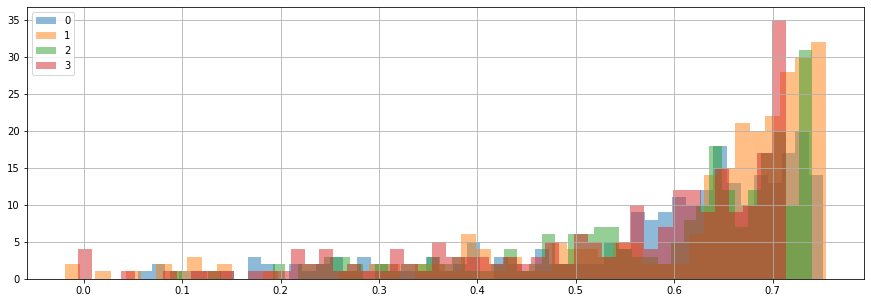

In [30]:
df.groupby('cluster').silhouette_score.hist(bins=50, alpha=0.5, legend=True, figsize=(15,5))
plt.show()

In [31]:
df.loc[df.silhouette_score<0.5].shape[0],df.shape[0]

(222, 968)

In [32]:
df['low_silhouette_flag'] = df.silhouette_score<0.3
df.low_silhouette_flag = df.low_silhouette_flag.astype(int)

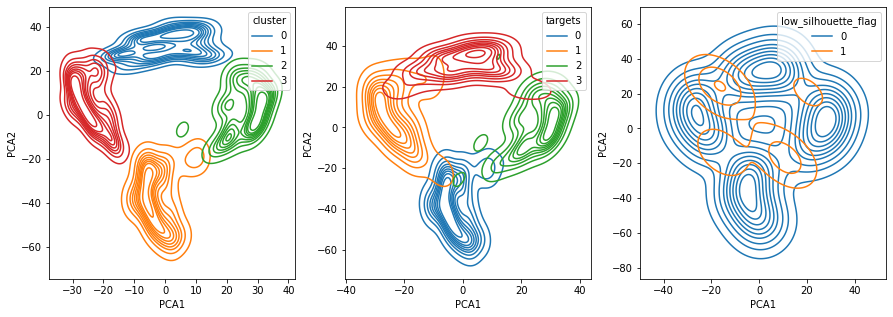

In [33]:
f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='cluster', palette= sns.color_palette()[0:4], ax=axes[0])
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='targets', palette= sns.color_palette()[0:4], ax=axes[1])
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='low_silhouette_flag', palette= sns.color_palette()[0:2], ax=axes[2])
plt.show()

#### END